In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error,median_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [4]:
df = pd.read_csv("api_1.csv")
df.head(5)

,Date,Process CPU usage,Process memory usage,Request count,Reponse time
0,2022-10-21 12:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00,3.77,6.30,312000.0,0.191


In [5]:
df.dropna(inplace=True)
df.columns = ['timestamp', 'cpu', 'memory', 'request', 'latency']
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))
df

,timestamp,cpu,memory,request,latency
0,2022-10-21 12:00:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00:00,3.77,6.30,312000.0,0.191
...,...,...,...,...,...
2156,2023-01-19 08:00:00,1.27,3.26,204000.0,0.157
2157,2023-01-19 09:00:00,1.35,3.26,211000.0,0.153
2158,2023-01-19 10:00:00,1.44,3.27,235000.0,0.141
2159,2023-01-19 11:00:00,2.23,3.27,644000.0,0.104


In [6]:
#separates 80% of this data
training_data_len = math.floor(len(df)*.8)

In [7]:
def create_predictors(y):

    lags = y[-1:-8:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

##CPU

In [8]:
start_cpu = time.time()

In [9]:
##CPU
#creating a training dataset
train_cpu = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_cpu['cpu'] = df[0:training_data_len]['cpu']
train_cpu.set_index('timestamp',inplace = True)

#creating the test base
test_cpu = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_cpu['cpu'] = df[training_data_len+1:]['cpu']
test_cpu.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

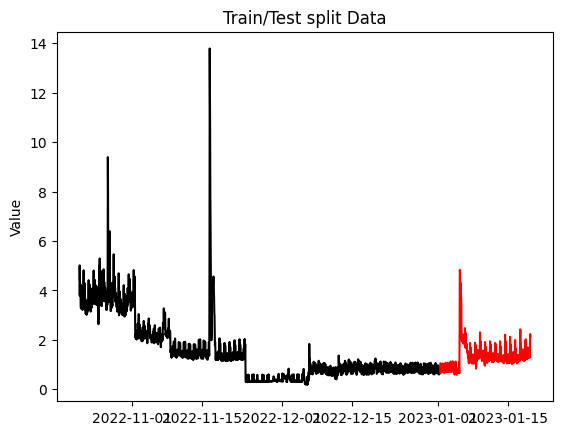

In [10]:
plt.plot(train_cpu, color = "black")
plt.plot(test_cpu, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [11]:
forecaster_cpu = ForecasterAutoregCustom(
  regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=100, learning_rate=0.3, colsample_bytree=1, subsample=1),
  fun_predictors = create_predictors,
  window_size = 120
)

forecaster_cpu.fit(y = train_cpu['cpu'])
forecaster_cpu

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoregCustom 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous 

In [12]:
horizon_cpu = test_cpu.shape[0]
predictions_cpu = forecaster_cpu.predict(steps=horizon_cpu)
predictions_cpu.index = test_cpu.index
predictions_cpu = pd.DataFrame(predictions_cpu)
predictions_cpu.columns = ['cpu']

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


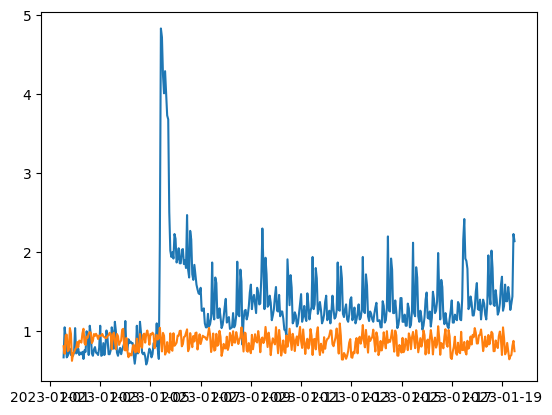

In [13]:
plt.plot(test_cpu.index, test_cpu.cpu)
plt.plot(predictions_cpu.index, predictions_cpu.cpu)

In [14]:
end_cpu = time.time()

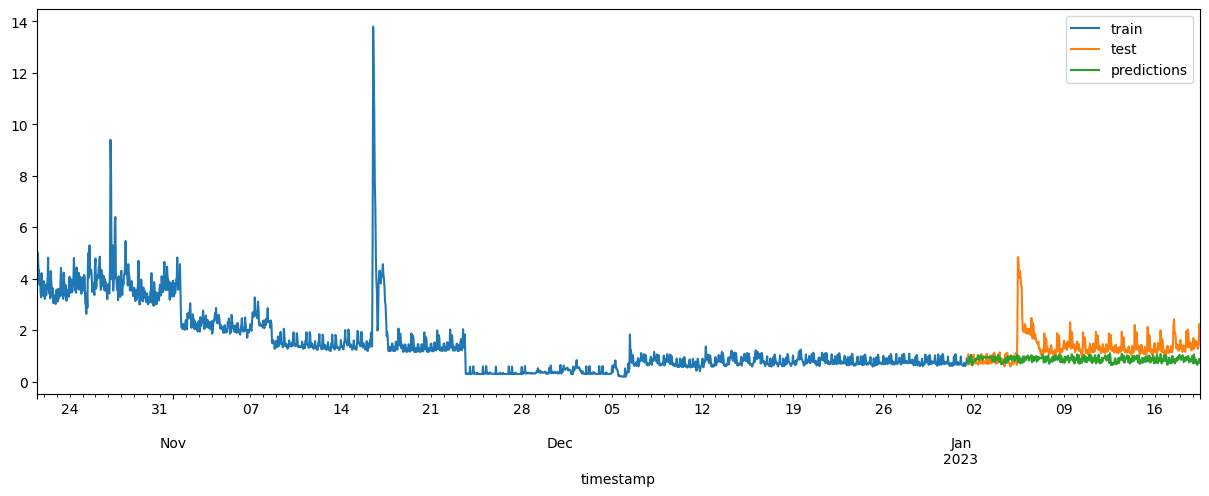

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train_cpu['cpu'].plot(ax=ax, label='train')
test_cpu['cpu'].plot(ax=ax, label='test')
predictions_cpu['cpu'].plot(ax=ax, label='predictions')
ax.legend()

In [16]:
print('Erro médio absoluto :', mean_absolute_error(test_cpu['cpu'], predictions_cpu['cpu']))
print('Erro médio quadrado :', mean_squared_error(test_cpu['cpu'], predictions_cpu['cpu']))
print('Coeficiente de determinação (R²):', r2_score(test_cpu['cpu'], predictions_cpu['cpu']))
print("Tempo de execução:", end_cpu-start_cpu)

Erro médio absoluto : 0.5015719480978118
Erro médio quadrado : 0.5095064830382661
Coeficiente de determinação (R²): -0.7324942477503407
Tempo de execução: 2.4025046825408936


##Memory

In [17]:
start_memory = time.time()

In [18]:
##Memory
#creating a training dataset
train_memory = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_memory['memory'] = df[0:training_data_len]['memory']
train_memory.set_index('timestamp',inplace = True)

#creating the test base
test_memory = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_memory['memory'] = df[training_data_len+1:]['memory']
test_memory.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

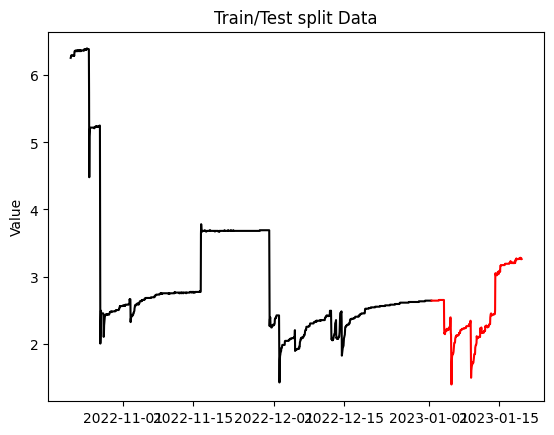

In [19]:
plt.plot(train_memory, color = "black")
plt.plot(test_memory, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [20]:
forecaster_memory = ForecasterAutoregCustom(
  regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=100, learning_rate=0.3, colsample_bytree=1, subsample=1),
  fun_predictors = create_predictors,
  window_size = 120
)

forecaster_memory.fit(y = train_memory['memory'])
forecaster_memory

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoregCustom 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous 

In [21]:
horizon_memory = test_memory.shape[0]
predictions_memory = forecaster_memory.predict(steps=horizon_memory)
predictions_memory.index = test_memory.index
predictions_memory = pd.DataFrame(predictions_memory)
predictions_memory.columns = ['memory']

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


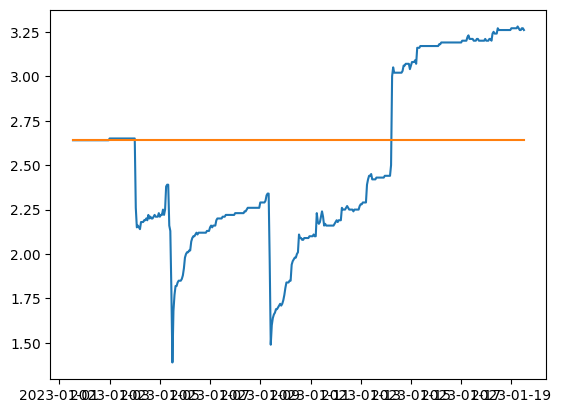

In [22]:
plt.plot(test_memory.index, test_memory.memory)
plt.plot(predictions_memory.index, predictions_memory.memory)

In [23]:
end_memory = time.time()

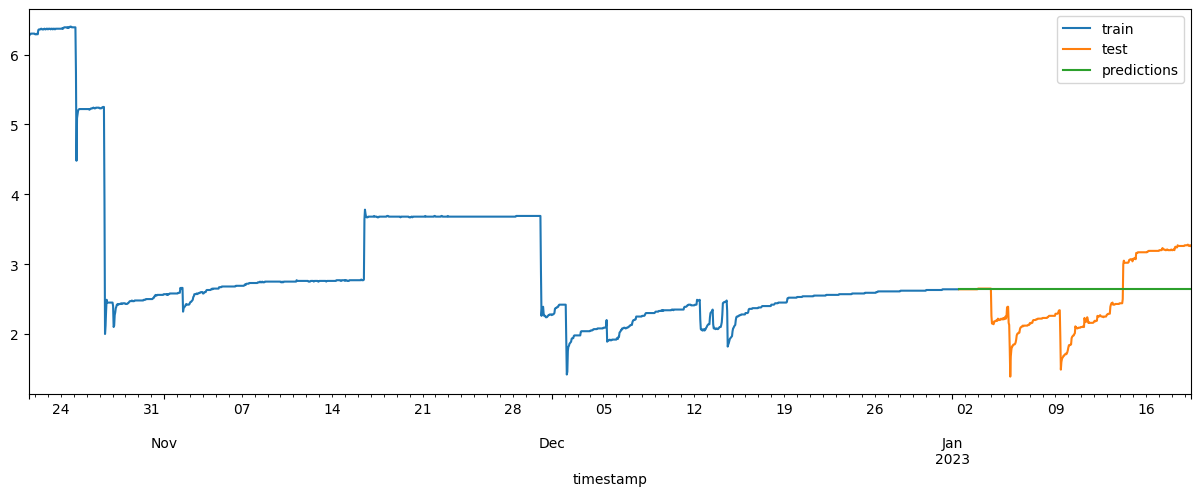

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
train_memory['memory'].plot(ax=ax, label='train')
test_memory['memory'].plot(ax=ax, label='test')
predictions_memory['memory'].plot(ax=ax, label='predictions')
ax.legend()

In [25]:
print('Erro médio absoluto :', mean_absolute_error(test_memory['memory'], predictions_memory['memory']))
print('Erro médio quadrado :', mean_squared_error(test_memory['memory'], predictions_memory['memory']))
print('Coeficiente de determinação (R²):', r2_score(test_memory['memory'], predictions_memory['memory']))
print("Tempo de execução:", end_memory-start_memory)

Erro médio absoluto : 0.43649194222909427
Erro médio quadrado : 0.24385440006591774
Coeficiente de determinação (R²): -0.06047371067689267
Tempo de execução: 1.1945717334747314


##Request

In [26]:
start_request = time.time()

In [27]:
##Request
#creating a training dataset
train_request = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_request['request'] = df[0:training_data_len]['request']
train_request.set_index('timestamp',inplace = True)

#creating the test base
test_request = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_request['request'] = df[training_data_len+1:]['request']
test_request.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

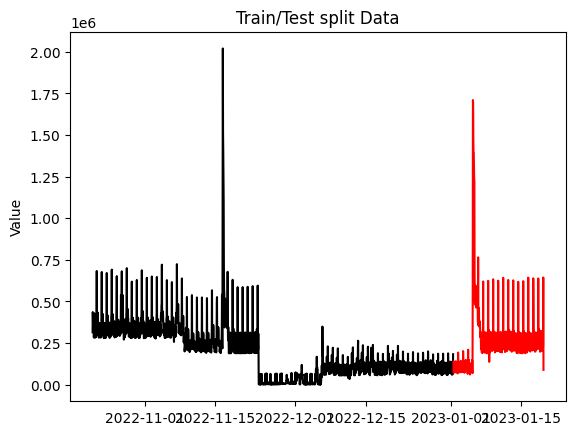

In [28]:
plt.plot(train_request, color = "black")
plt.plot(test_request, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [29]:
forecaster_request = ForecasterAutoregCustom(
  regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=100, learning_rate=0.3, colsample_bytree=1, subsample=1),
  fun_predictors = create_predictors,
  window_size = 120
)

forecaster_request.fit(y = train_request['request'])
forecaster_request

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoregCustom 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous 

In [30]:
horizon_request = test_request.shape[0]
predictions_request = forecaster_request.predict(steps=horizon_request)
predictions_request.index = test_request.index
predictions_request = pd.DataFrame(predictions_request)
predictions_request.columns = ['request']

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


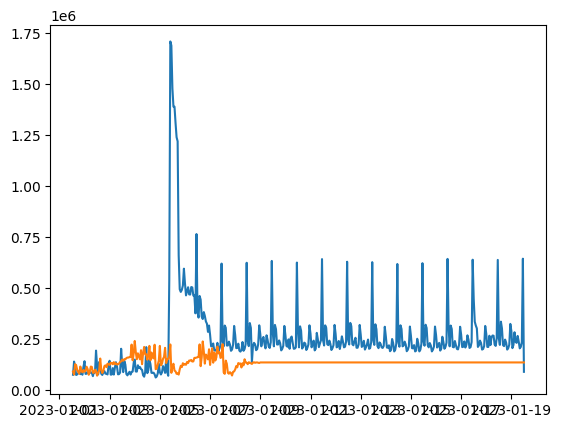

In [31]:
plt.plot(test_request.index, test_request.request)
plt.plot(predictions_request.index, predictions_request.request)

In [32]:
end_request = time.time()

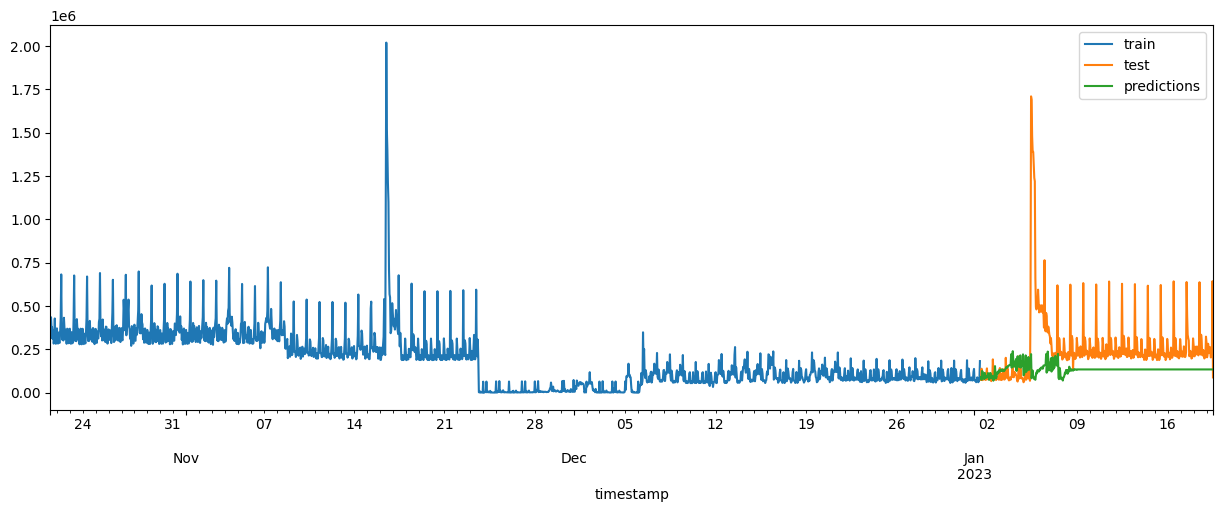

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
train_request['request'].plot(ax=ax, label='train')
test_request['request'].plot(ax=ax, label='test')
predictions_request['request'].plot(ax=ax, label='predictions')
ax.legend()

In [34]:
print('Erro médio absoluto :', mean_absolute_error(test_request['request'], predictions_request['request']))
print('Erro médio quadrado :', mean_squared_error(test_request['request'], predictions_request['request']))
print('Coeficiente de determinação (R²):', r2_score(test_request['request'], predictions_request['request']))
print("Tempo de execução:", end_request-start_request)

Erro médio absoluto : 138875.78830295138
Erro médio quadrado : 56465501531.14292
Coeficiente de determinação (R²): -0.3866073515688371
Tempo de execução: 1.6342647075653076


##Latency

In [35]:
start_latency = time.time()

In [36]:
##Latency
#creating a training dataset
train_latency = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_latency['latency'] = df[0:training_data_len]['latency']
train_latency.set_index('timestamp',inplace = True)

#creating the test base
test_latency = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_latency['latency'] = df[training_data_len+1:]['latency']
test_latency.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

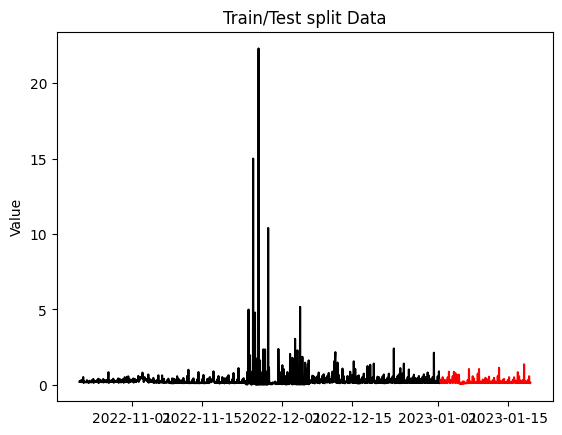

In [37]:
plt.plot(train_latency, color = "black")
plt.plot(test_latency, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [38]:
forecaster_latency = ForecasterAutoregCustom(
  regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=100, learning_rate=0.3, colsample_bytree=1, subsample=1),
  fun_predictors = create_predictors,
  window_size = 120
)

forecaster_latency.fit(y = train_latency['latency'])
forecaster_latency

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoregCustom 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 120 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous 

In [39]:
horizon_latency = test_latency.shape[0]
predictions_latency = forecaster_latency.predict(steps=horizon_latency)
predictions_latency.index = test_latency.index
predictions_latency = pd.DataFrame(predictions_latency)
predictions_latency.columns = ['latency']

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


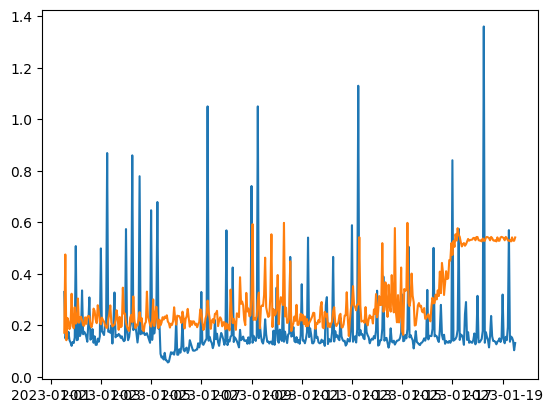

In [40]:
plt.plot(test_latency.index, test_latency.latency)
plt.plot(predictions_latency.index, predictions_latency.latency)

In [41]:
end_latency = time.time()

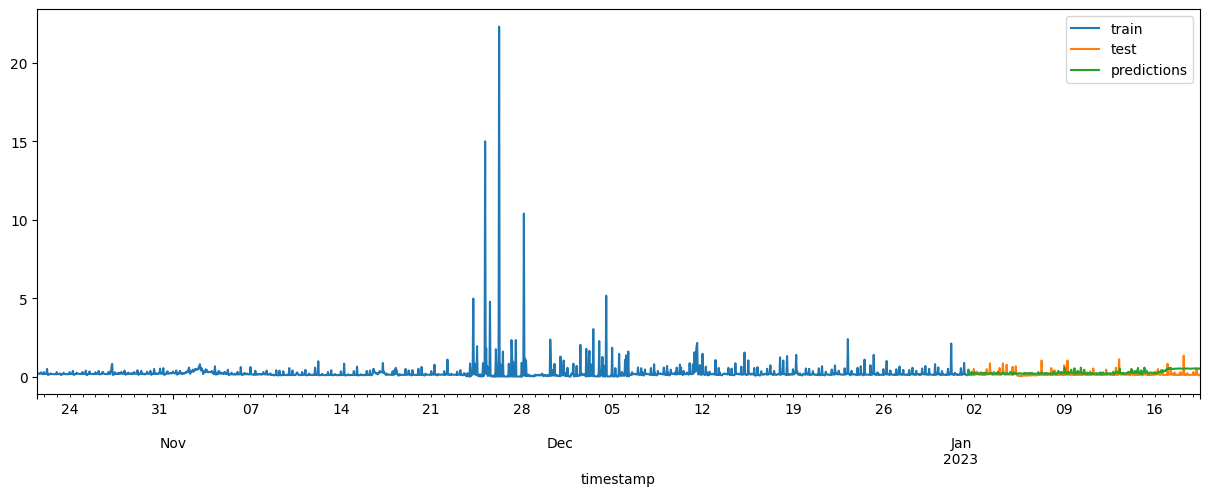

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))
train_latency['latency'].plot(ax=ax, label='train')
test_latency['latency'].plot(ax=ax, label='test')
predictions_latency['latency'].plot(ax=ax, label='predictions')
ax.legend()

In [43]:
print('Erro médio absoluto :', mean_absolute_error(test_latency['latency'], predictions_latency['latency']))
print('Erro médio quadrado :', mean_squared_error(test_latency['latency'], predictions_latency['latency']))
print('Coeficiente de determinação (R²):', r2_score(test_latency['latency'], predictions_latency['latency']))
print("Tempo de execução:", end_latency-start_latency)

Erro médio absoluto : 0.15741648726993135
Erro médio quadrado : 0.044587155821380474
Coeficiente de determinação (R²): -1.1488109623596618
Tempo de execução: 11.141409397125244
